# Predictive Modelling: LightGBM

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# 
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# 
from src.models.predict_model import avg_model, run_combinations
#from src.models.train_model import run_combinations 

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position, calc_returns
from src.visualization.visualize import plot_confusion_matrix
from atomm.Methods import BlockingTimeSeriesSplit, PurgedKFold           


import time

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBClassifier

#from sklearn.ensemble import BaggingClassifier
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# For BayesianHyperparameter Optimization
from atomm.Models.Tuning import search_space#, BayesianSearch
from hyperopt import space_eval

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

In [2]:
##### Load environment variables
load_dotenv(find_dotenv())

True

In [3]:
R_STATE = 16818

## Loading the data

In [4]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')


In [5]:
fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
#fname = '../data/processed/index.h5'

In [6]:
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    ws = storage.get('nyse/engineered/weights')

    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()
print(df_moments.shape, y_3c.shape, y_2c.shape, djia.shape, ws.shape)

(1954, 4800) (1954, 450) (1954, 450) (1954, 250) (1954, 450)


In [7]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

In [8]:
df_moments.columns.get_level_values(1).unique()

Index(['macd_3', 'rsi_3', 'stoc_3', 'roc_3', 'bbu_3', 'bbl_3', 'ema_3',
       'atr_3', 'adx_3', 'cci_3', 'williamsr_3', 'stocd_3', 'macd_5', 'rsi_5',
       'stoc_5', 'roc_5', 'bbu_5', 'bbl_5', 'ema_5', 'atr_5', 'adx_5', 'cci_5',
       'williamsr_5', 'stocd_5', 'macd_7', 'rsi_7', 'stoc_7', 'roc_7', 'bbu_7',
       'bbl_7', 'ema_7', 'atr_7', 'adx_7', 'cci_7', 'williamsr_7', 'stocd_7',
       'macd_10', 'rsi_10', 'stoc_10', 'roc_10', 'bbu_10', 'bbl_10', 'ema_10',
       'atr_10', 'adx_10', 'cci_10', 'williamsr_10', 'stocd_10', 'macd_15',
       'rsi_15', 'stoc_15', 'roc_15', 'bbu_15', 'bbl_15', 'ema_15', 'atr_15',
       'adx_15', 'cci_15', 'williamsr_15', 'stocd_15', 'macd_20', 'rsi_20',
       'stoc_20', 'roc_20', 'bbu_20', 'bbl_20', 'ema_20', 'atr_20', 'adx_20',
       'cci_20', 'williamsr_20', 'stocd_20', 'macd_25', 'rsi_25', 'stoc_25',
       'roc_25', 'bbu_25', 'bbl_25', 'ema_25', 'atr_25', 'adx_25', 'cci_25',
       'williamsr_25', 'stocd_25', 'macd_30', 'rsi_30', 'stoc_30', 'ro

## Imputing missing values

In [9]:
X.shape

(1954, 4800)

In [10]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [11]:
prices.shape

(1954, 250)

In [12]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [13]:
y_3c.shape

(1954, 450)

In [14]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [15]:
y2.shape

(1954, 450)

In [16]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

In [17]:
check_for_missing_vals(ws)

No missing values found in dataframe


In [18]:
ws.shape

(1954, 450)

# Scaling the features

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [20]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [21]:
scaled = scale.fit_transform(X)

In [22]:
scaled.shape

(1954, 4800)

In [23]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = scaled

# Train-Test Split

In [24]:
# Use 90/10 train/test splits
test_p = .2

In [25]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [26]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]


In [27]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [28]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

In [29]:
# Splitting sample weights

In [30]:
ws_train, ws_test = ws[:test_size], ws[test_size:]
prices_train, prices_test = prices[:test_size], prices[test_size:]


# Model

In [31]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [32]:
symbol = 'AOS'
n1 = 15
n2 = 15
n_estimators = 10
# set up cross validation splits
tscv = TimeSeriesSplit(n_splits=5)
btscv = BlockingTimeSeriesSplit(n_splits=5)
#ppcv = PurgedKFold(n_splits=5)

In [33]:
# Creates a list of features for a given lookback window (n1)
features = [f'{x}_{n1}' for x in ti_list]
# Creates a list of all features
all_features = [f'{x}_{n}' for x in ti_list for n in input_window_size]

## Define custom loss functions w/ penalty for FP / FN

In [34]:
# Define custom loss function which adds penalty for falsely classifying as positive

def custom_loss_function(y_true, y_pred):
    beta = 1E-1
    p    = 1. / (1 + np.exp(-y_pred))
    grad = p * ((beta -1) * y_true + 1) - beta * y_true
    hess = ((beta - 1) * y_true + 1) * p * (1.0 - p)
    return grad, hess
    

In [35]:
def logloss_penalize_fp(y_true, y_pred):
    beta = 1.3
    p    = 1. / (1 + np.exp(-y_pred))
    st = (y_true - beta * (y_true - 1))
    # Gradient: ((beta-(1-beta)*y_true) - y_true) * p
    grad = st * p - y_true
    # Hessian: ((beta-(1-beta)*y_true) - y_true) * p * (1 - p)
    hess = st * p * (1.0 - p) 
    return grad, hess

## Single lookback/lookahead w/o hyperparameter optimization

In [36]:
clf_lgbm = LGBMClassifier(random_state=R_STATE)
clf_lgbm.set_params(
    **{'objective': logloss_penalize_fp},
    metrics = ['logloss'],
    #learning_rate=1E-1,
    #num_iterations=200,
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metrics=['logloss'], min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31,
               objective=<function logloss_penalize_fp at 0x1a20fbc9e0>,
               random_state=16818, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
X_tr=X_train[symbol][[f'{x}_{n1}' for x in ti_list]]
y_tr=y_train[symbol][f'signal_{n2}']

clf_lgbm.fit(
    X=X_tr,
    y=y_tr
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metrics=['logloss'], min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31,
               objective=<function logloss_penalize_fp at 0x1a20fbc9e0>,
               random_state=16818, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

              precision    recall  f1-score   support

           0       0.32      0.71      0.44        89
           1       0.86      0.55      0.67       302

    accuracy                           0.58       391
   macro avg       0.59      0.63      0.55       391
weighted avg       0.74      0.58      0.62       391



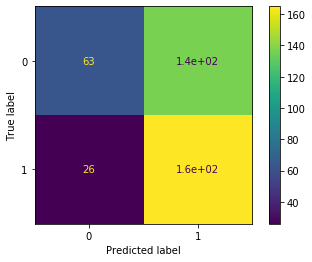

In [38]:
y_pred_lgbm1 = clf_lgbm.predict(X_test[symbol][[f'{x}_{n1}' for x in ti_list]])
print(classification_report(y_pred_lgbm1, y_test[symbol][f'signal_{n2}']))

plot_confusion_matrix(
    clf_lgbm,
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    #normalize='all'
)


In [39]:
calc_returns(y_pred_lgbm1, signals_baseline=1, prices=djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_Baseline
Epoch,,,,
2018-04-20 00:00:00+00:00,NaN,0,NaN,NaN
2018-04-23 00:00:00+00:00,-0.005669,0,0.000000,-0.005669
2018-04-24 00:00:00+00:00,-0.042989,1,-0.042989,-0.048658
2018-04-25 00:00:00+00:00,-0.009821,1,-0.052811,-0.058479
2018-04-26 00:00:00+00:00,0.018699,0,-0.052811,-0.039780
...,...,...,...,...
2019-10-31 00:00:00+00:00,-0.013894,0,-0.469699,-0.220008
2019-11-01 00:00:00+00:00,0.012077,0,-0.469699,-0.207931
2019-11-04 00:00:00+00:00,0.011535,1,-0.458164,-0.196396


## Single lookback/lookahead with hyperparameter optimization

In [40]:
def returns_score(y_true, y_pred, data):
    return calc_returns(y_pred, signals_baseline = 1, prices = data)['Cum_Returns_Strat'][-1]


In [41]:
from atomm.Models.Tuning import search_space
from atomm.Models.Tuning import BayesianOptimizer
from hyperopt import space_eval

In [42]:
w_tr = ws_train[symbol][f'weight_{n2}']/ws_train[symbol][f'weight_{n2}'].max()
w_te = ws_test[symbol][f'weight_{n2}']/ws_test[symbol][f'weight_{n2}'].max()

In [43]:
features

['macd_15',
 'rsi_15',
 'stoc_15',
 'roc_15',
 'bbu_15',
 'bbl_15',
 'ema_15',
 'atr_15',
 'adx_15',
 'cci_15',
 'williamsr_15',
 'stocd_15']

In [45]:
feature_list = ['macd_10', 'stoc_10']

In [66]:
opt = BayesianOptimizer(
    param_space=search_space(LGBMClassifier),
    model=LGBMClassifier,
    X_train=X_train[symbol][feature_list],
    y_train=y_train[symbol][f'signal_{n2}'],
    #weight_train=w_tr,
    X_test=X_test[symbol][feature_list],
    y_test=y_test[symbol][f'signal_{n2}'],
    #weight_test=w_te,
    valid_data=prices_train[symbol]['Close'],
    valid_metric=returns_score,
    num_eval=10,
)

In [84]:
from hyperopt import hp

In [86]:
opt.set_params(objective=logloss_penalize_fp)
#opt.set_params(metrics='logloss')
opt.set_params(cv=hp.choice('cv', ['btscv', 'tscv']))
opt.set_params(random_state=R_STATE)
test_score, clf_best, best_param = opt.optimize()

 10%|█         | 1/10 [00:00<00:01,  5.61trial/s, best loss: -0.0]

/Users/robin/anaconda3/envs/capstone_nf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until



100%|██████████| 10/10 [00:09<00:00,  1.02trial/s, best loss: -0.3360246221224467]
##### Results #####
Score best parameters:  -0.3360246221224467
Best parameters:  {'colsample_bytree': 0.4615493852837521, 'cv': 'tscv', 'learning_rate': 0.3508101459709309, 'max_depth': 85, 'min_child_samples': 62, 'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'n_estimators': 299, 'num_leaves': 94, 'objective': <function logloss_penalize_fp at 0x1a20fbc9e0>, 'random_state': 16818}
Test Score (accuracy):  0.5396419437340153
Parameter combinations evaluated:  10


Recall Score:  0.5396419437340153
              precision    recall  f1-score   support

           0       0.40      0.57      0.47       140
           1       0.69      0.52      0.59       251

    accuracy                           0.54       391
   macro avg       0.54      0.55      0.53       391
weighted avg       0.58      0.54      0.55       391



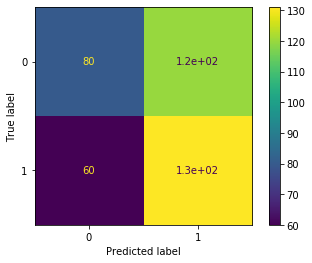

In [87]:
y_pred_bsearch_lgbm = clf_best.predict(X_test[symbol][feature_list])
print('Recall Score: ', recall_score(y_pred_bsearch_lgbm, y_test[symbol][f'signal_{n2}'], average='weighted'))
print(classification_report(y_pred_bsearch_lgbm, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_best,
    X_test[symbol][feature_list], y_test[symbol][f'signal_{n2}'],
)

In [88]:
calc_returns(y_pred_bsearch_lgbm, signals_baseline=1, prices=prices_test[symbol])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_Baseline
Epoch,,,,
2018-04-20 00:00:00+00:00,NaN,0,NaN,NaN
2018-04-23 00:00:00+00:00,-0.005669,1,-0.005669,-0.005669
2018-04-24 00:00:00+00:00,-0.042989,1,-0.048658,-0.048658
2018-04-25 00:00:00+00:00,-0.009821,0,-0.048658,-0.058479
2018-04-26 00:00:00+00:00,0.018699,1,-0.029959,-0.039780
...,...,...,...,...
2019-10-31 00:00:00+00:00,-0.013894,1,-0.584357,-0.220008
2019-11-01 00:00:00+00:00,0.012077,1,-0.572279,-0.207931
2019-11-04 00:00:00+00:00,0.011535,1,-0.560744,-0.196396


In [89]:
returns = prices_test[symbol].pct_change().copy()
returns['pred'] = y_pred_bsearch_lgbm


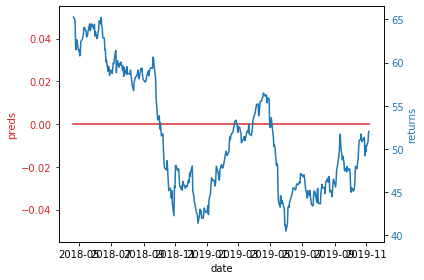

In [76]:
fig, ax1 = plt.subplots(sharex=True)

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('preds', color=color)
ax1.plot(returns.index, returns['pred'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('returns', color=color)  # we already handled the x-label with ax1
ax2.plot(returns.index, prices_test[symbol]['Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.hlines(0, dt.datetime(2019, 1, 1), dt.datetime(2019, 5, 10))
#plt.xlim(dt.datetime(2019, 1, 1), dt.datetime(2019, 5, 10))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()